In [1]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [20]:
import wfdb
import numpy as np
import os
import csv
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

In [21]:
def downsample_by_averaging(signal, factor):
    downsampled_signal = []
    
    for i in range(0, len(signal), factor): # moves by index of 8
        chunk = signal[i:i+factor, :] 
        downsampled_signal.append(np.mean(chunk, axis=0))  # avg of each column
        
    return np.array(downsampled_signal)


In [22]:
data_list=[] #takes all the subjects 
directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
csv_path = os.path.join(directory, 'subjectinfo.csv') 
for i in range(1,21):
    ACCTEMPEDA_Path = os.path.join(directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file

    # ACCTEMPEDA_DownSampled = downsample_by_averaging(ACCTEMPEDA_Record.p_signal, 8) # downsample ACCTEMP EDA as it is 8 HZ
    # ACCTEMPEDA_DownSampled_Record = wfdb.Record(
    #     record_name=f'Subject{i}_AccTempEDA_DownSampled', 
    #     p_signal=ACCTEMPEDA_DownSampled, 
    #     fs=1,
    #     sig_name=ACCTEMPEDA_Record.sig_name,
    #     units=ACCTEMPEDA_Record.units        
    # )
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['subject']) == i:
                data_list.append({
                    'subject_id': i,
                    'acc_temp_eda': ACCTEMPEDA_Record,
                    'spo2_hr': SPO2HR_Record,
                    'annotations': annotations,
                    'age': int(row['age']),
                    'gender': row['gender'],
                    'height_cm': int(row['height/cm']),
                    'weight_kg': int(row['weight/kg'])
                })
                #print(f"Subject {i} Metadata:")
                #print(f"  Age: {int(row['age'])}")
                #print(f"  Gender: {row['gender']}")
                #print(f"  Height (cm): {int(row['height/cm'])}")
                #print(f"  Weight (kg): {int(row['weight/kg'])}")
                

In [23]:
sub = data_list[1]
#print()
print(sub['acc_temp_eda'].p_signal)

[[ 0.96997131 -0.67005829 -0.07004547 28.70009461  0.81804387]
 [ 0.96997131 -0.6800177  -0.07004547 28.90009461  0.81804387]
 [ 0.97998291 -0.67005829 -0.07004547 28.90009461  0.81601674]
 ...
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.02999969 -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]]


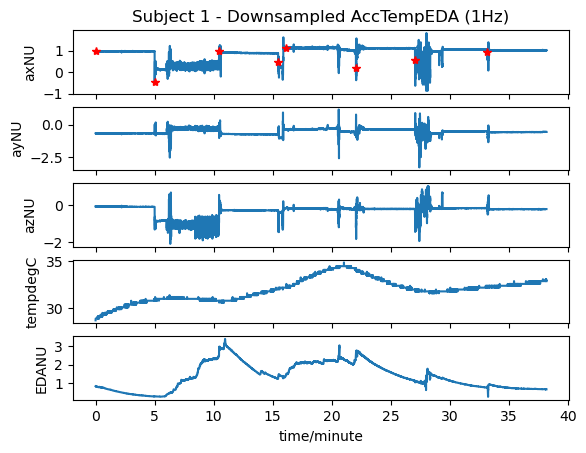

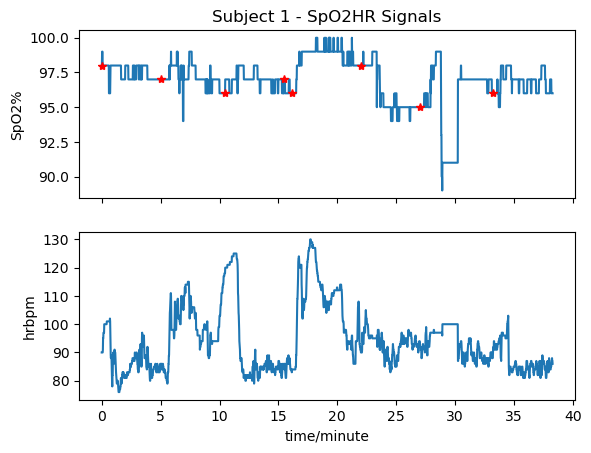

In [24]:
subject = data_list[1]  
wfdb.plot_wfdb( record=subject['acc_temp_eda'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - Downsampled AccTempEDA (1Hz)')
wfdb.plot_wfdb( record=subject['spo2_hr'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - SpO2HR Signals')

In [185]:
# val is 1 incase labels are included 0 otherwise 
def preprocess(wavevec):
    final_vec = [] # stores the filtered signals
    for i in range(0,len(wavevec[0])): # goes through each point in the signal
        one_col = [wavevec[s][i].astype(float) for s in range(0,len(wavevec))] # filters column by column
        one_col = medfilt(one_col, kernel_size=9) # filtering each column
        if i == 0:
            final_vec = one_col
        else:
            final_vec = np.column_stack((final_vec, one_col))
    return final_vec

In [186]:
preprocess(sub['acc_temp_eda'])

TypeError: 'Record' object is not subscriptable

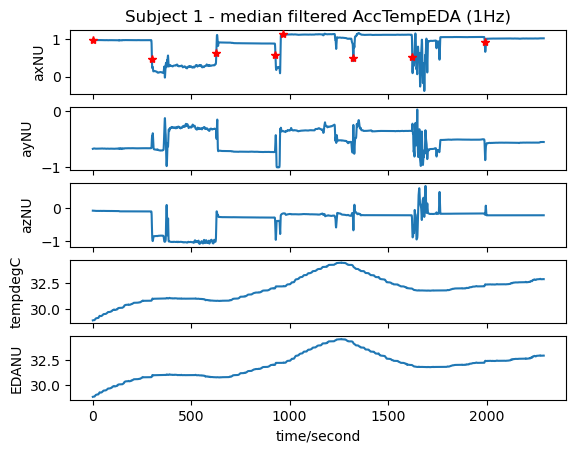

In [188]:
sub['acc_temp_eda'].p_signal = preprocess(sub['acc_temp_eda'].p_signal)
wfdb.plot_wfdb( record=sub['acc_temp_eda'], annotation=subject['annotations'], time_units='seconds', title='Subject 1 - median filtered AccTempEDA (1Hz)')

In [124]:
preprocess(sub['acc_temp_eda'])

TypeError: preprocess() missing 1 required positional argument: 'val'

In [125]:
sub['acc_temp_eda'].p_signal = preprocess(sub['acc_temp_eda'])
wfdb.plot_wfdb( record=sub['acc_temp_eda'], annotation=subject['annotations'], time_units='seconds', title='Subject 1 - gaussian filtered AccTempEDA (1Hz)')

TypeError: preprocess() missing 1 required positional argument: 'val'

# Extracting and Combining Data by Class

## Utility functions

In [172]:
# extract the ranges of each stage from their annotation
def get_stages(annotation, size):
    stages = []
    for i, (samp, note) in enumerate(zip(annotation.sample, annotation.aux_note)):
        stages.append({"Label" : note, "start": samp, "end": 0}) # dummy end
    
    for i in range((len(stages) - 1)):
        stages[i]["end"] = stages[i+1]["start"] # each stages end is the next one's beginning
    stages[-1]["end"] = size # set the end of last stage as the length of the data

    return stages  

In [173]:
# find label of a data point at a given index based on the ranges of each stage
def find_label(stages, index):
    for stage in stages:
        if index >= stage['start'] and index < stage['end']:
            return stage["Label"]
    return "Unknown"

In [174]:
# label the AccTempEDA data
def extract_labeled_AccTempEDA(record, annotation):
    stages = get_stages(annotation, record.p_signal.shape[0]) # get the range for each stage
    data = record.p_signal # extract the data into a numpy array
    labels = [] # array to store the labels corresponding to each data point in the record
    for idx, entry in enumerate(data): # loop over all the data
        labels.append((find_label(stages, idx))) # find the label based on the points index
    labeled_data = np.column_stack((data, labels)) # append the labels column to the data 
    return labeled_data # return the labeled data

In [175]:
# downsample by averaging BUT make sure you stay within a given class
def downsample_by_averaging(data, factor):
    downsampled_data = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, :-1].astype(float) # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            avg_chunk = np.mean(chunk, axis=0)
            downsampled_data.append(np.append(avg_chunk, class_label))  # avg of each column while adding back the label
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
                    
    return np.array(downsampled_data)

In [176]:
# combine AccTempEDA and Spo2HR data while truncating them to be of the same length
# CRUCIAL but naive assumption! time stamps match after downsampling (technically incorrect)
def combine(AccTempEDA, Spo2HR):
    min_length = min(len(AccTempEDA), len(Spo2HR)) # finds the minimum length to align the points properly

    # concatenate the truncated columns from AccTempEDA with those from Spo2HR and add the labels at the end
    combined_data = np.column_stack((AccTempEDA[:min_length, :-1], Spo2HR[:min_length], AccTempEDA[:min_length, -1:]))

    return combined_data

In [206]:
# get the full data for each subject
def get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [199]:
def get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

# Function to read and get raw data for all subjects and store them in csvs

In [207]:
read_directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
type = "Preprocessed"
write_directory= f"Subject Data {type}"
all_sub_info = []
for i in range(1,21):
    csv_path = os.path.join(write_directory, f'subject_{i}_data_{type}.csv')
    ACCTEMPEDA_Path = os.path.join(read_directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(read_directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file
    subject_data = get_subject_data_preprocessed(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    all_sub_info.append(subject_data)
    # #print(f'subject{i}: {len(subject_data)}') 
    # with open(csv_path, mode='w', newline='') as csvfile:
    #     writer = csv.writer(csvfile)
    #     # Write headers
    #     writer.writerow(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'HR', 'label'])
    #     # Write each row of subject data
    #     for row in subject_data:
    #         writer.writerow(row)

In [208]:
len(all_sub_info)

20

In [211]:
def windowSel(sample,val):
    # stores the windowed sample
    new_samp = []
    # stores the last i in case the window exceeds the size of the sample
    fin_i = 0
    for i in range(0,len(sample),val):
        # checks if i exceeds the sample size
        if i + val >= len(sample):
            fin_i = i
        else:
            # adds the windowed sample
            new_samp.append(sample[i - val:i])
    # adds the missing samples
    if fin_i != 0:
        new_samp.append(sample[fin_i:len(sample) - 1])
    return new_samp

In [217]:
windowed_samps = []
val = 5
for i in range(0,20):
   windowSel(all_sub_info[1],val)
    